# **0. Импорт сторонних библиотек**

In [2]:
# Исключение предупреждающих сообщений
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install missingno
!pip install xgboost
!pip install lightgbm
!pip install imblearn

In [3]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report, make_scorer
plt.style.use('fivethirtyeight')
from sklearn import feature_selection
from sklearn import model_selection

%matplotlib inline
sns.set_style('white')

# **1. Загрузка данных**

In [4]:
from google.colab import drive #Импортируем библиотеку для работы с Google Drive
drive.mount("/content/drive") #Монтируем Google-диск. После этой операции мы можем считывать файлы со своего Google-диска.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Для больших файлов - читаем и обрабатываем по частям
chunk_size = 100000  # Размер чанка для обработки
# Базовый путь к папке
base_path = 'train_data/'

# Список для хранения датафреймов
dfs = []

for i in range(12):
    file_path = f'{base_path}train_data_{i}.pq'
    print(f'Обработка файла: {file_path}')

    try:
        # Читаем parquet файл
        df = pd.read_parquet(file_path)

        # Можно добавить предобработку здесь
        # Например, преобразование типов для экономии памяти
        # df = reduce_memory_usage(df)

        dfs.append(df)
        print(f'Загружено: {df.shape}')

    except Exception as e:
        print(f'Ошибка: {e}')

# Объединяем
df_all = pd.concat(dfs, ignore_index=True)

# Оптимизация памяти после объединения
def reduce_memory_usage(df):
    """Оптимизация использования памяти"""
    convert_columns = df.columns.drop('id')
    for col in convert_columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int8')
    return df

df_all = reduce_memory_usage(df_all)
print(f'Финальный размер: {df_all.shape}')
print(f'Использование памяти: {df_all.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

Обработка файла: train_data/train_data_0.pq
Загружено: (1974724, 61)
Обработка файла: train_data/train_data_1.pq
Загружено: (2107305, 61)
Обработка файла: train_data/train_data_2.pq
Загружено: (2080508, 61)
Обработка файла: train_data/train_data_3.pq
Загружено: (2112592, 61)
Обработка файла: train_data/train_data_4.pq
Загружено: (2064110, 61)
Обработка файла: train_data/train_data_5.pq
Загружено: (2150908, 61)
Обработка файла: train_data/train_data_6.pq
Загружено: (2176452, 61)
Обработка файла: train_data/train_data_7.pq
Загружено: (2222245, 61)
Обработка файла: train_data/train_data_8.pq
Загружено: (2242615, 61)
Обработка файла: train_data/train_data_9.pq
Загружено: (2284256, 61)
Обработка файла: train_data/train_data_10.pq
Загружено: (2296372, 61)
Обработка файла: train_data/train_data_11.pq
Загружено: (2450630, 61)
Финальный размер: (26162717, 61)
Использование памяти: 1696.65 MB


In [ ]:
# Базовый путь к папке
base_path = '/content/drive/MyDrive/Colab Notebooks/data/'

# Список для хранения датафреймов
dfs = []

# Загружаем все 12 файлов
for i in range(12):
    file_path = f'{base_path}df_{i}.csv'
    print(f'Загрузка файла: {file_path}')

    try:
        df = pd.read_csv(file_path)
        dfs.append(df)
        print(f'Успешно загружен, размер: {df.shape}')
    except Exception as e:
        print(f'Ошибка при загрузке {file_path}: {e}')

# Объединяем все датафреймы
if dfs:
    df_all = pd.concat(dfs, ignore_index=True)
    print(f'\nОбщий размер объединенного датафрейма: {df_all.shape}')
else:
    print('Не удалось загрузить ни одного файла')

Загрузка файла: /content/drive/MyDrive/Colab Notebooks/data/df_0.csv
Успешно загружен, размер: (1974724, 62)
Загрузка файла: /content/drive/MyDrive/Colab Notebooks/data/df_1.csv
Успешно загружен, размер: (2107305, 62)
Загрузка файла: /content/drive/MyDrive/Colab Notebooks/data/df_2.csv
Успешно загружен, размер: (2080508, 62)
Загрузка файла: /content/drive/MyDrive/Colab Notebooks/data/df_3.csv
Успешно загружен, размер: (2112592, 62)
Загрузка файла: /content/drive/MyDrive/Colab Notebooks/data/df_4.csv
Успешно загружен, размер: (2064110, 62)
Загрузка файла: /content/drive/MyDrive/Colab Notebooks/data/df_5.csv
Успешно загружен, размер: (2150908, 62)
Загрузка файла: /content/drive/MyDrive/Colab Notebooks/data/df_6.csv
Успешно загружен, размер: (2176452, 62)
Загрузка файла: /content/drive/MyDrive/Colab Notebooks/data/df_7.csv
Успешно загружен, размер: (2222245, 62)
Загрузка файла: /content/drive/MyDrive/Colab Notebooks/data/df_8.csv
Успешно загружен, размер: (2242615, 62)
Загрузка файла: /co

In [ ]:
# Скачаивание файла
targets = 'train_target.csv'
#file_path = '/content/drive/MyDrive/Colab Notebooks/train_data/train_data_11.pq'

#df = pd.read_parquet(file_path)

In [ ]:
df_all.head(5)

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [ ]:
# Соединение файла данный с таргетом
target_df = pd.read_csv(targets)
df_all = pd.merge(df_all, target_df[['id', 'flag']], on='id', how='left')

# **2. Data Preparation**

## **2.1 Исследование данных**

In [ ]:
df_all.shape

(26162717, 62)

In [ ]:
df_all.dtypes

id                       int64
rn                        int8
pre_since_opened          int8
pre_since_confirmed       int8
pre_pterm                 int8
                         ...  
enc_loans_credit_type     int8
enc_loans_account_cur     int8
pclose_flag               int8
fclose_flag               int8
flag                     int64
Length: 62, dtype: object

In [ ]:
# Сохраним файл csv с измененным типом данных
df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/df_11.csv', index=False)

In [ ]:
# Создадим HTML-таблицы для характеристик
html_table = "<table>"
for column in df.columns:
    null_count = df[column].isnull().sum()
    if null_count > 0:
        html_table += f'<tr><td><b>{column}</b></td><td>{null_count}</td><td>пропущено</td></tr>'
    else:
        html_table += f'<tr><td><b>{column}</b></td><td>0</td><td>не имеет пропусков</td></tr>'
html_table += "</table>"

# Добавление статистических характеристик
html_table += df.describe(include='all').to_html()

# Отображение таблицы
display(HTML(html_table))

id,0,не имеет пропусков
rn,0,не имеет пропусков
pre_since_opened,0,не имеет пропусков
pre_since_confirmed,0,не имеет пропусков
pre_pterm,0,не имеет пропусков
pre_fterm,0,не имеет пропусков
pre_till_pclose,0,не имеет пропусков
pre_till_fclose,0,не имеет пропусков
pre_loans_credit_limit,0,не имеет пропусков
pre_loans_next_pay_summ,0,не имеет пропусков
pre_loans_outstanding,0,не имеет пропусков


Вывод:
- в датафрейме нет пропущенных значений;
- в датафрейме нет выбросов и аномалий;
- наблюдаем два вида признаков: бинарные (принимают 2 значения) и закодированные (изначально категориальные).

Для удобства создадим отдельные списки бинарных и закодированных признаков

In [ ]:
# Список бинарных признаков, без столбца flag
binary_columns = []
for column in df_all.columns:
    if column != 'flag' and df_all[column].nunique() == 2:
        binary_columns.append(column)

binary_columns

['pre_loans_total_overdue',
 'is_zero_loans5',
 'is_zero_loans530',
 'is_zero_loans3060',
 'is_zero_loans6090',
 'is_zero_loans90',
 'is_zero_util',
 'is_zero_over2limit',
 'is_zero_maxover2limit',
 'pclose_flag',
 'fclose_flag']

In [ ]:
# Список закодированных столбцов
# Создаем список столбцов, которые нужно исключить
columns_for_drop = ['flag', 'id', 'rn'] + binary_columns

categorical_columns = df_all.columns.difference(columns_for_drop).tolist()
categorical_columns

['enc_loans_account_cur',
 'enc_loans_account_holder_type',
 'enc_loans_credit_status',
 'enc_loans_credit_type',
 'enc_paym_0',
 'enc_paym_1',
 'enc_paym_10',
 'enc_paym_11',
 'enc_paym_12',
 'enc_paym_13',
 'enc_paym_14',
 'enc_paym_15',
 'enc_paym_16',
 'enc_paym_17',
 'enc_paym_18',
 'enc_paym_19',
 'enc_paym_2',
 'enc_paym_20',
 'enc_paym_21',
 'enc_paym_22',
 'enc_paym_23',
 'enc_paym_24',
 'enc_paym_3',
 'enc_paym_4',
 'enc_paym_5',
 'enc_paym_6',
 'enc_paym_7',
 'enc_paym_8',
 'enc_paym_9',
 'pre_fterm',
 'pre_loans3060',
 'pre_loans5',
 'pre_loans530',
 'pre_loans6090',
 'pre_loans90',
 'pre_loans_credit_cost_rate',
 'pre_loans_credit_limit',
 'pre_loans_max_overdue_sum',
 'pre_loans_next_pay_summ',
 'pre_loans_outstanding',
 'pre_maxover2limit',
 'pre_over2limit',
 'pre_pterm',
 'pre_since_confirmed',
 'pre_since_opened',
 'pre_till_fclose',
 'pre_till_pclose',
 'pre_util']

In [ ]:
# Функция для вывода графиков зависимости значения flag от разных признаков
def plot_categorical_distributions(data, categorical_features, flag_column='flag', cols=2):
    # Определяем количество графиков в строке
    num_rows = (len(categorical_features) + cols - 1) // cols

    # Создаем фигуру и оси
    fig, axes = plt.subplots(num_rows, cols, figsize=(cols * 8, num_rows * 6), constrained_layout=True)

    # Преобразуем оси в массив, если это необходимо
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    # Обходим все признаки и создаем графики
    for i, feature in enumerate(categorical_features):
        ax = axes[i // cols, i % cols]

        # Фильтруем данные по флагу
        flag_0_data = data[data[flag_column] == 0][feature]
        flag_1_data = data[data[flag_column] == 1][feature]

        # Настройки гистограммы
        bins = np.linspace(min(data[feature]), max(data[feature]), 15)

        # Подготовка данных для гистограмм
        hist0, bins0 = np.histogram(flag_0_data, bins=bins)
        hist1, bins1 = np.histogram(flag_1_data, bins=bins)

        # Нормализация ширины бинов для отображения в bar plot
        width = np.diff(bins0).min()

        # Рисуем гистограммы
        rects1 = ax.bar(bins0[:-1], hist0, width=width, align='center', alpha=0.5, label='Flag 0', color='blue')
        rects2 = ax.bar(bins1[:-1] + width, hist1, width=width, align='center', alpha=0.5, label='Flag 1', color='red')

        # Добавляем названия и метки
        ax.set_title(f'Distribution of {feature} by Flag')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.legend()

        # Функция для добавления процентов на столбцы
        def autolabel(rects, total):
            for rect in rects:
                height = rect.get_height()
                if height > 0:  # Добавляем аннотацию только если высота столбца больше 0
                    ax.annotate(f'{height/total:.2%}',
                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                xytext=(0, 3),  # смещение метки на 3 пункта вверх
                                textcoords="offset points",
                                ha='center', va='bottom')

        # Применяем функцию autolabel для добавления процентов
        autolabel(rects1, len(flag_0_data))
        autolabel(rects2, len(flag_1_data))

    # Убираем ненужные оси
    for i in range(len(categorical_features), len(axes.flat)):
        fig.delaxes(axes.flatten()[i])

    # Показываем графики
    plt.show()

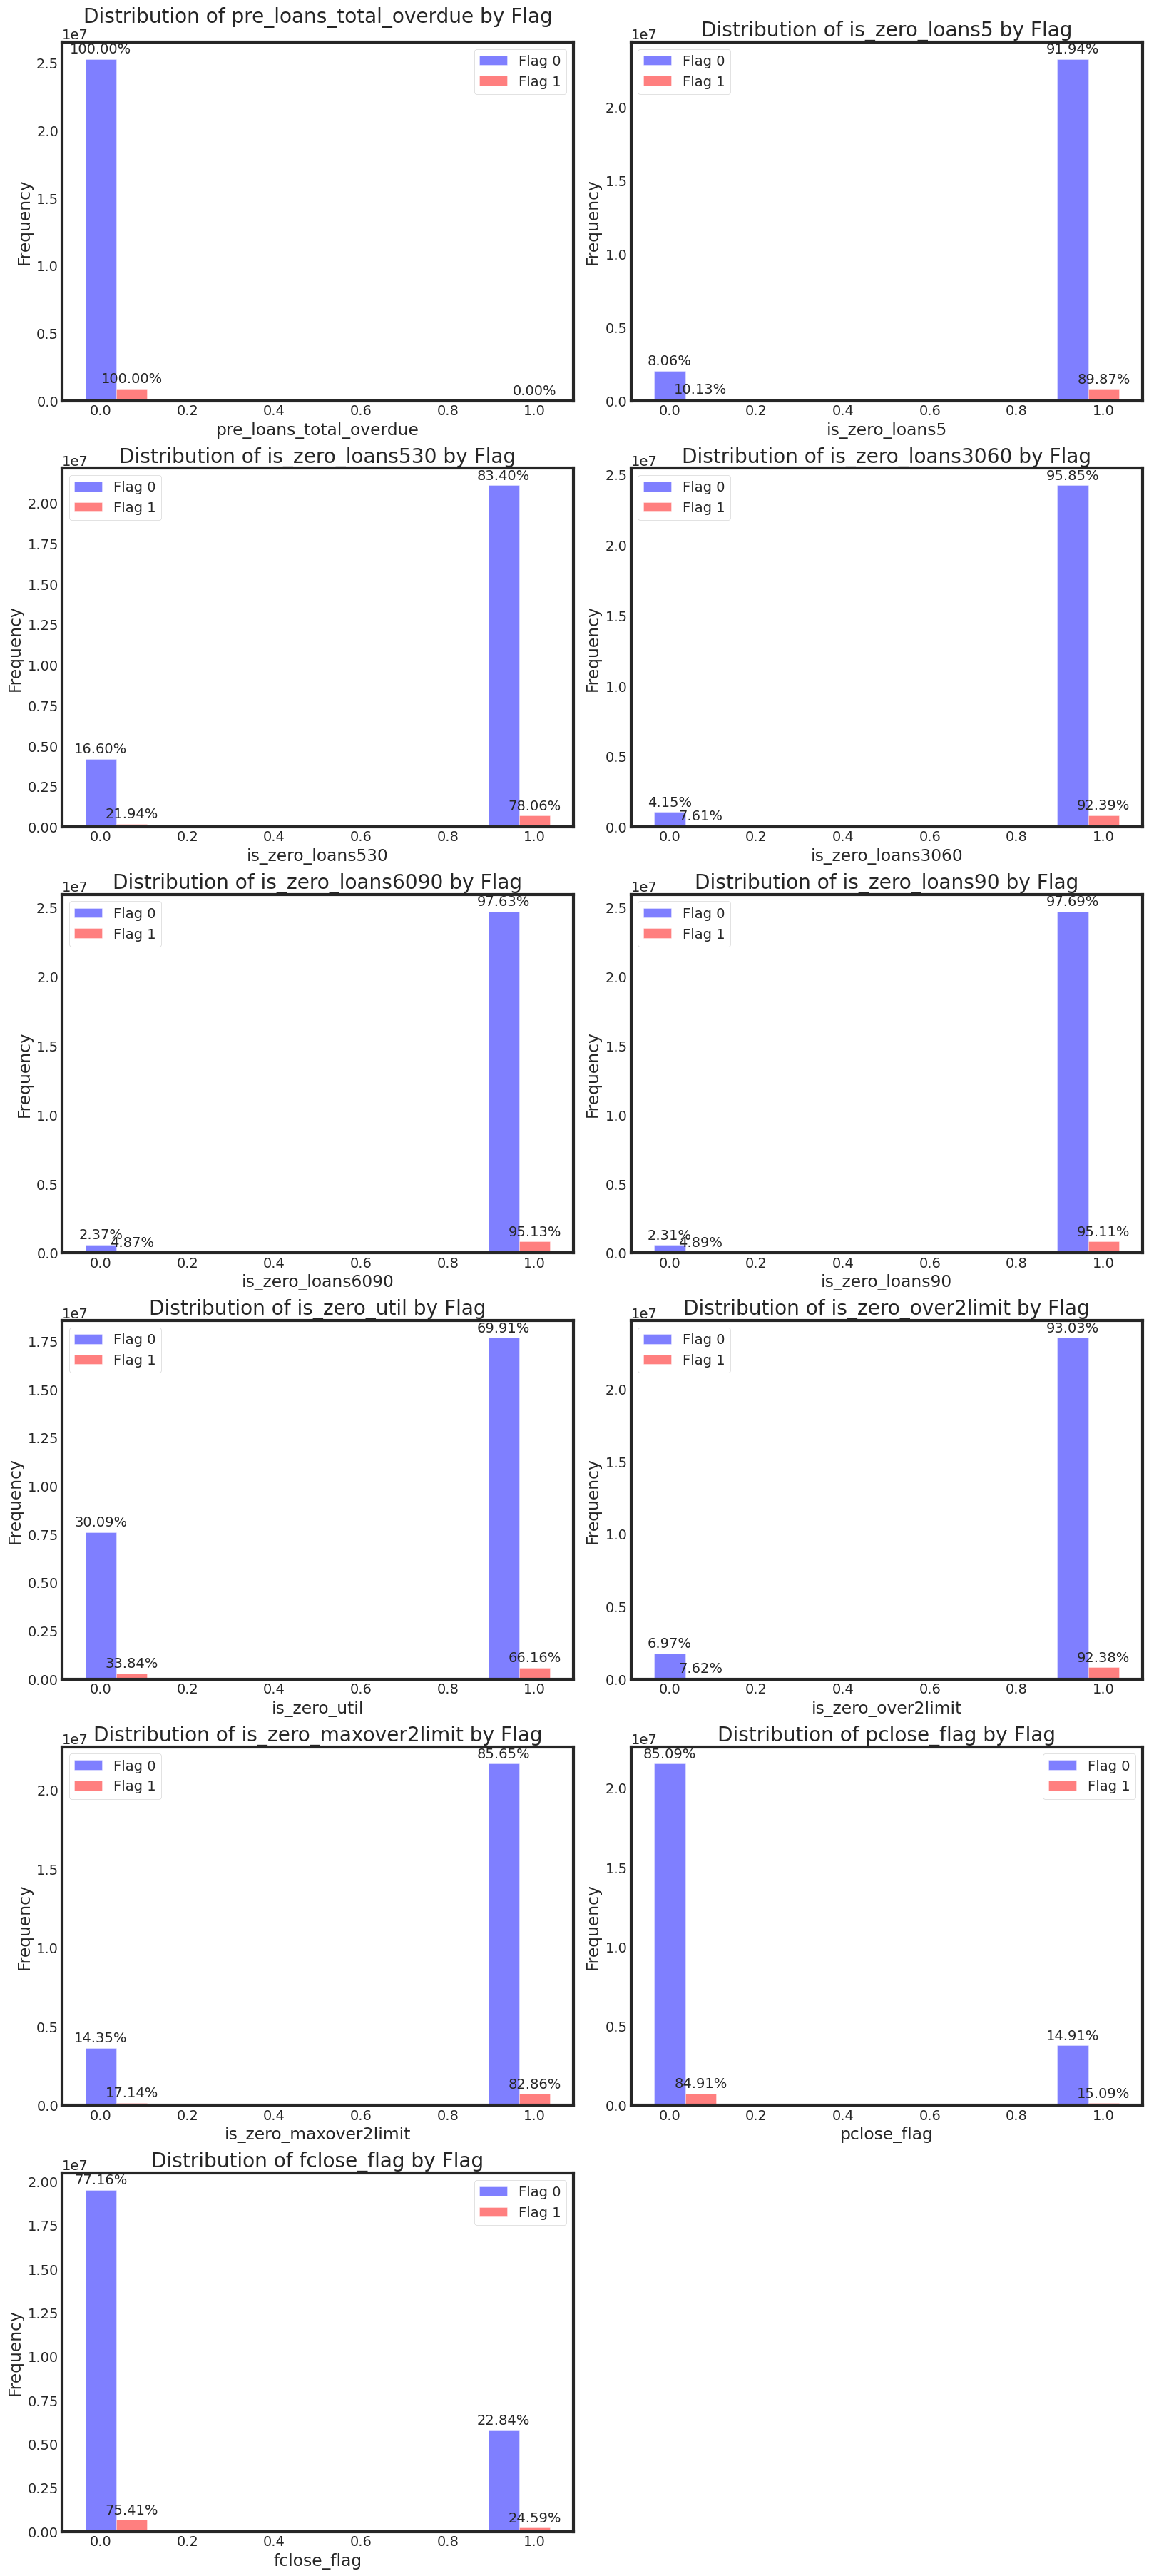

In [ ]:
plot_categorical_distributions(df_all, binary_columns, flag_column='flag', cols=2)

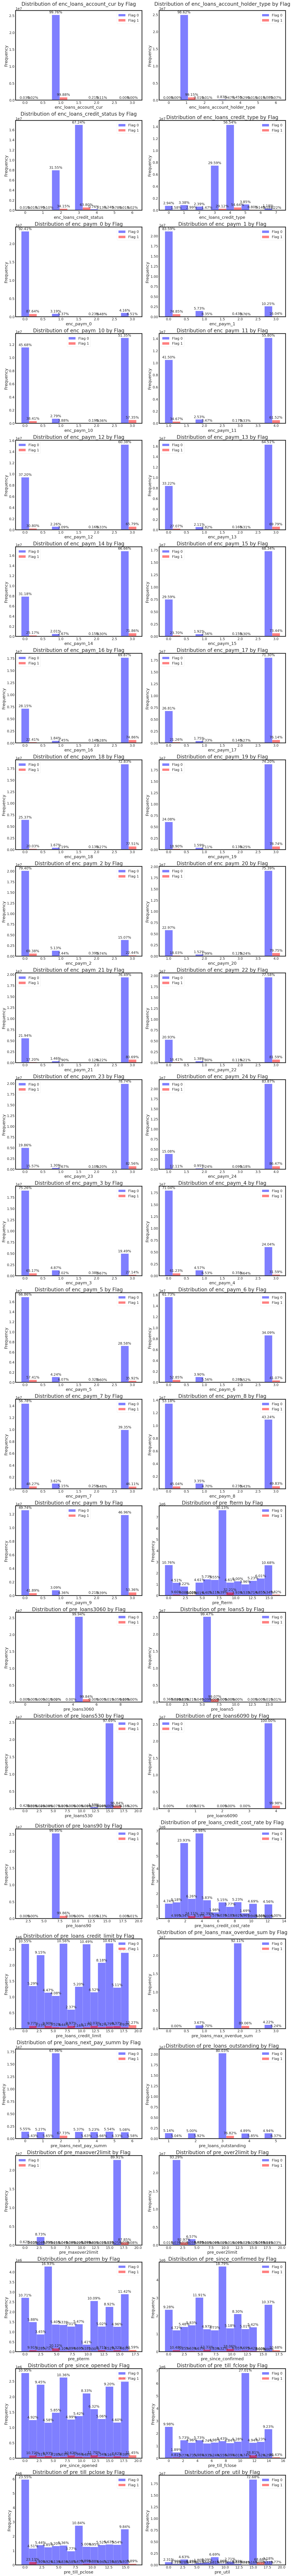

In [ ]:
plot_categorical_distributions(df_all, categorical_columns, flag_column='flag', cols=2)

В результате поиска различных зависимостей целевой переменной от признаков, не было найдено каких-то сильных взаимосвязей.

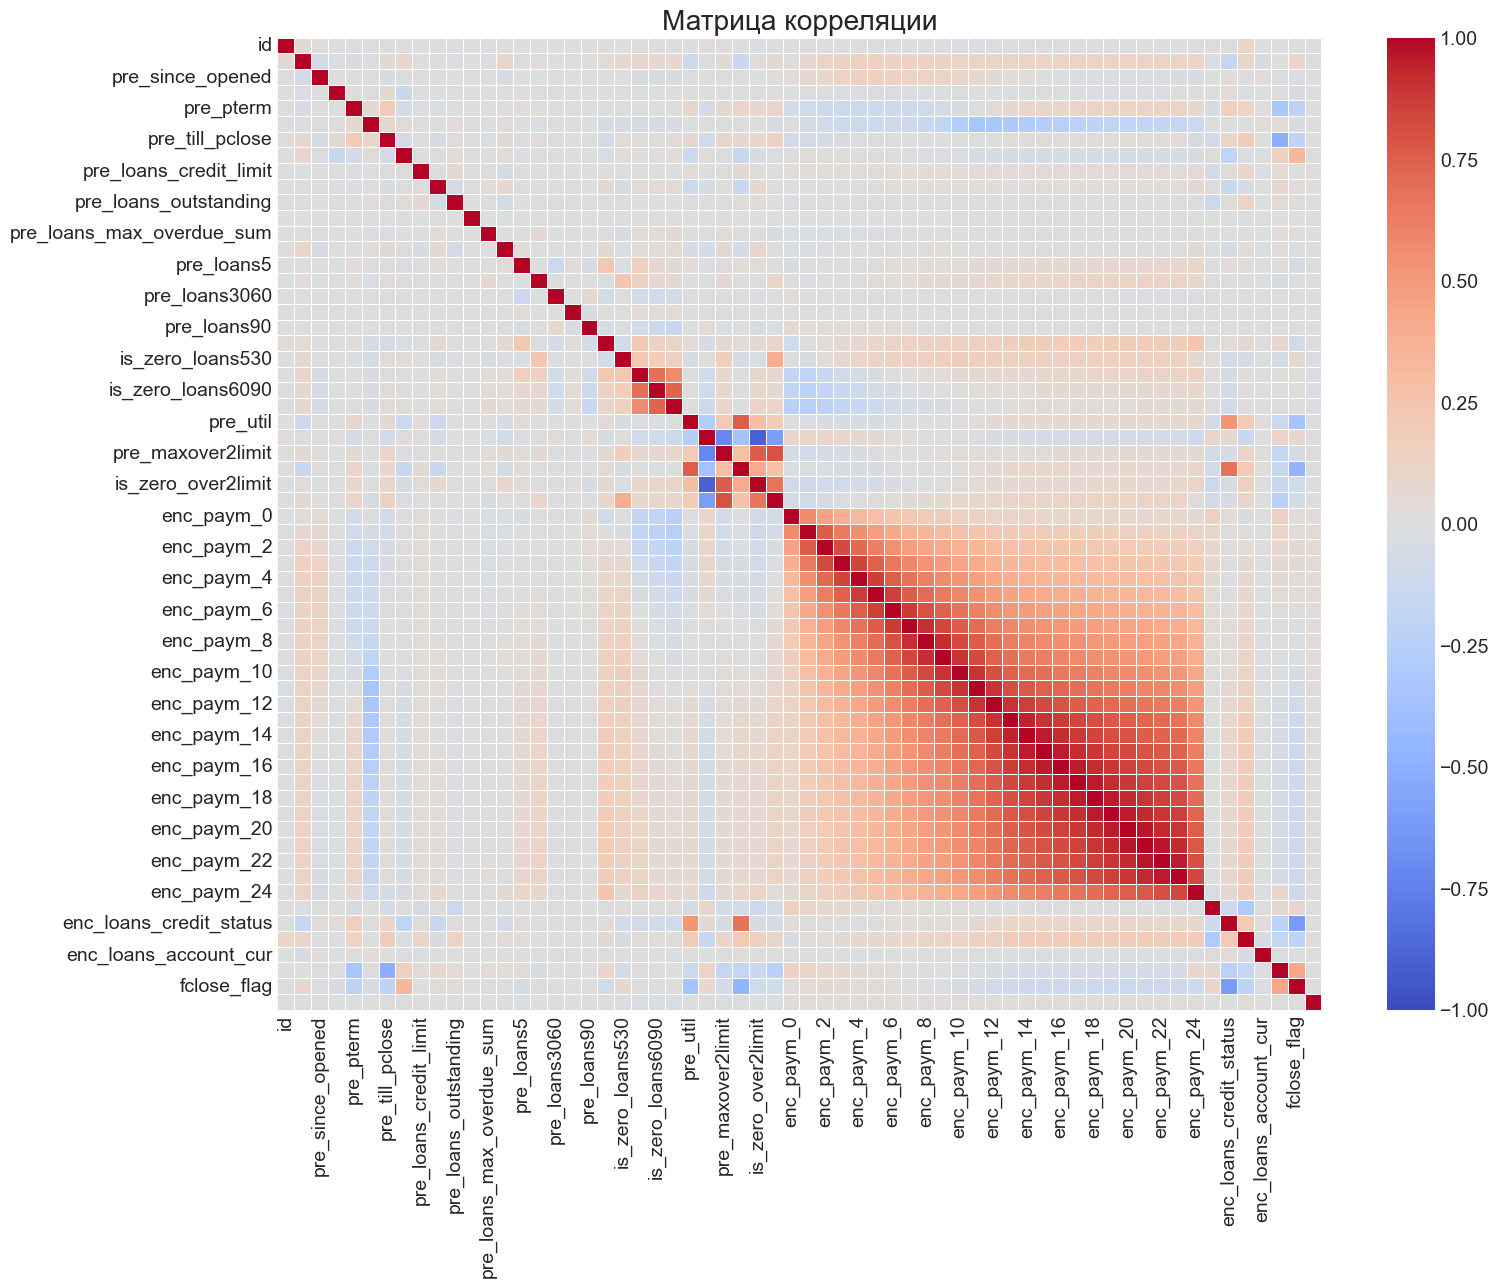

In [ ]:
# Пострим матрицу корреляции
corr_matrix = df_all.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

Корреляции больше 0.8 по модулю:
            Feature1            Feature2  Correlation
1578  pre_over2limit  is_zero_over2limit        -0.90
2017      enc_paym_2          enc_paym_3         0.83
2080      enc_paym_3          enc_paym_4         0.85
2143      enc_paym_4          enc_paym_5         0.87
2206      enc_paym_5          enc_paym_6         0.86
...              ...                 ...          ...
3214     enc_paym_21         enc_paym_22         0.96
3215     enc_paym_21         enc_paym_23         0.93
3277     enc_paym_22         enc_paym_23         0.96
3278     enc_paym_22         enc_paym_24         0.81
3340     enc_paym_23         enc_paym_24         0.84

[61 rows x 3 columns]


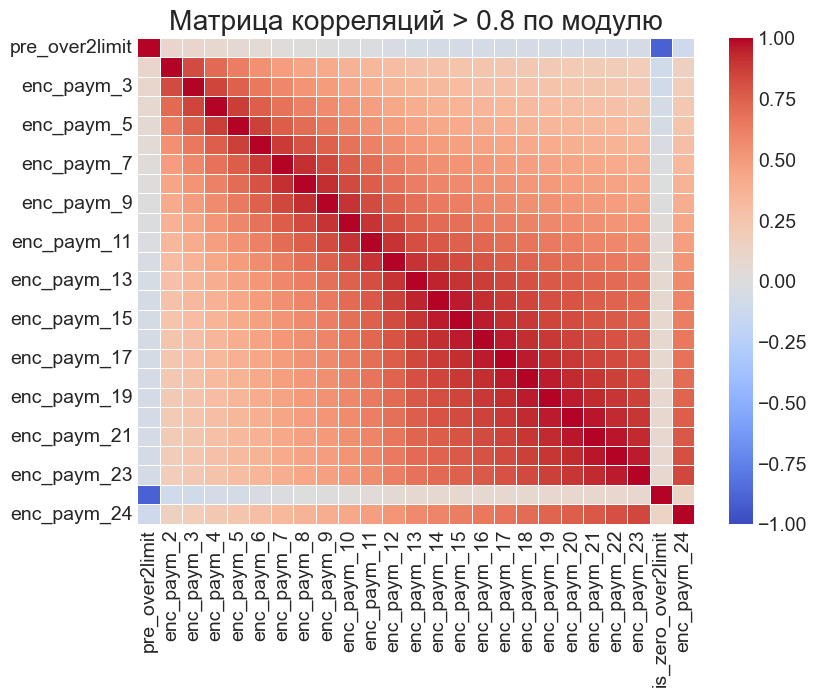

In [ ]:
# Построим матрицу корреляции для признаков со значением корреляции больше 0,8
# Преобразование корреляционной матрицы в длинный формат
corr_long = corr_matrix.unstack().reset_index()
corr_long.columns = ['Feature1', 'Feature2', 'Correlation']

# Исключение самокорреляций
corr_long = corr_long[corr_long['Feature1'] != corr_long['Feature2']]

# Удаление дубликатов
corr_long = corr_long.drop_duplicates(subset=['Correlation'])

# Округление корреляций до двух десятичных знаков
corr_long['Correlation'] = corr_long['Correlation'].round(2)

# Фильтрация корреляций по условию |Correlation| > 0.8
high_corr = corr_long[corr_long['Correlation'].abs() > 0.8]

# Печать корреляций больше 0.8 по модулю
print("Корреляции больше 0.8 по модулю:")
print(high_corr)

# Извлечение уникальных признаков
high_corr_features = pd.unique(high_corr[['Feature1', 'Feature2']].values.ravel('K'))

# Создание новой корреляционной матрицы для этих признаков
high_corr_matrix = df_all[high_corr_features].corr()

# Построение тепловой карты для высоких корреляций
plt.figure(figsize=(8, 6))
sns.heatmap(high_corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Матрица корреляций > 0.8 по модулю')
plt.show()

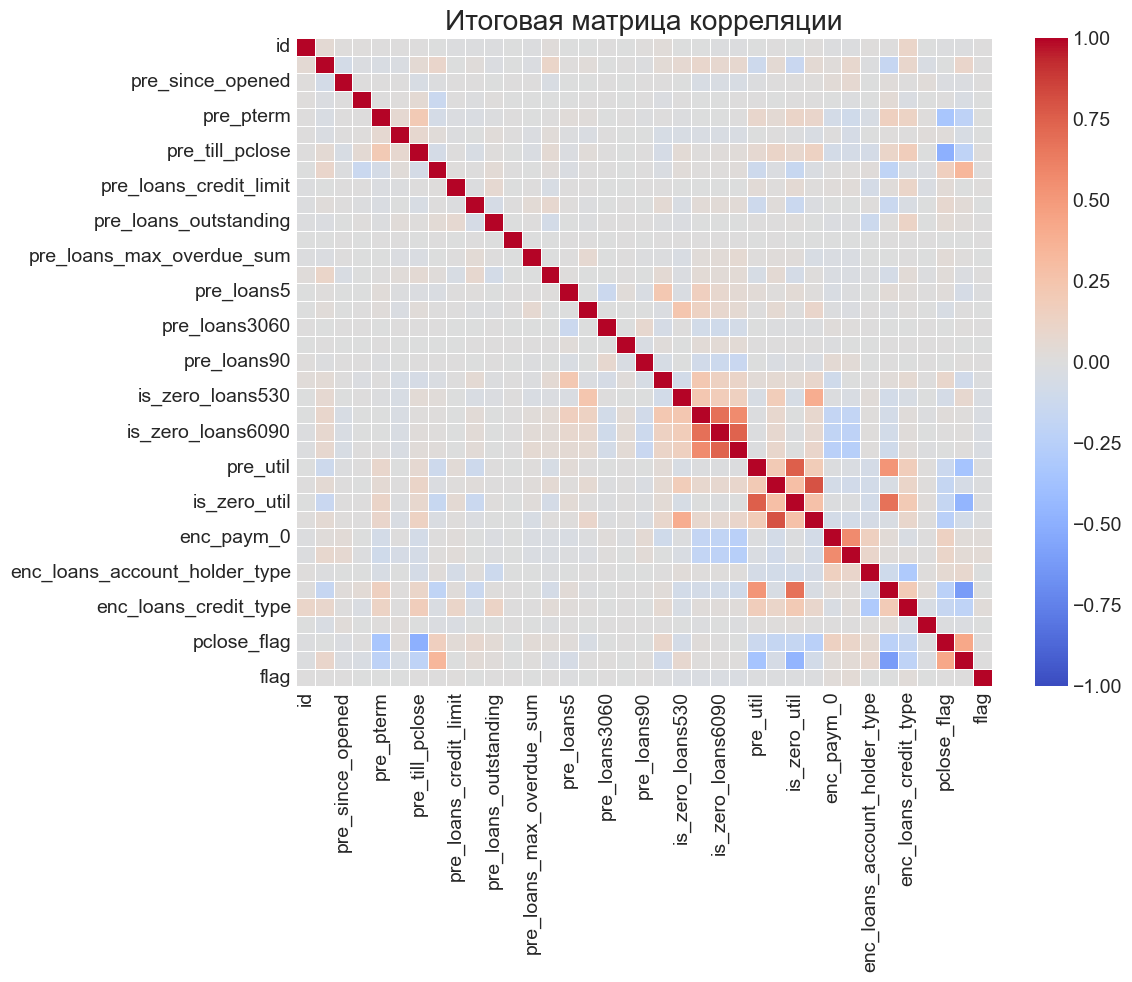

In [ ]:
# Удалим признаки со значением корреляции больше 0,8
df_clean = df_all.drop(columns=high_corr_features)

# Построение итоговой матрицы корреляции
corr_matrix_clean = df_clean.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_clean, annot= False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Итоговая матрица корреляции')
plt.show()

In [ ]:
# Анализ пропущенных значений
missing_analysis = df_clean.isnull().sum()
missing_percentage = (df_clean.isnull().sum() / len(df)) * 100

# Создаем DataFrame с анализом
missing_df = pd.DataFrame({
    'missing_count': missing_analysis,
    'missing_percentage': missing_percentage
})

# Сортируем по убыванию процента пропусков
missing_df = missing_df.sort_values('missing_percentage', ascending=False)

# Выводим признаки с пропусками
features_with_missing = missing_df[missing_df['missing_count'] > 0]
print("Признаки с пропущенными значениями:")
print(features_with_missing)

print(f"\nВсего признаков с пропусками: {len(features_with_missing)}")
print(f"Общее количество признаков: {df.shape[1]}")

Признаки с пропущенными значениями:
Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []

Всего признаков с пропусками: 0
Общее количество признаков: 61


In [ ]:
import sys

# Получение всех датафреймов в текущем пространстве имен
dataframes = [obj for obj in globals().values() if isinstance(obj, pd.DataFrame)]

total_memory_usage = 0
for df in dataframes:
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # Преобразование в мегабайты
    total_memory_usage += memory_usage

print("Общее использование памяти всех датафреймов: {:.2f} MB".format(total_memory_usage))

Общее использование памяти всех датафреймов: 4355.35 MB


In [ ]:
# Получение всех датафреймов в текущем пространстве имен
dataframes = {name: obj for name, obj in globals().items() if isinstance(obj, pd.DataFrame)}

for name, df in dataframes.items():
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # Преобразование в мегабайты
    print("Датафрейм '{}' использует {:.2f} MB памяти".format(name, memory_usage))

Датафрейм '___' использует 0.00 MB памяти
Датафрейм 'df' использует 0.00 MB памяти
Датафрейм 'df_all' использует 1896.25 MB памяти
Датафрейм '_5' использует 0.00 MB памяти
Датафрейм 'target_df' использует 45.78 MB памяти
Датафрейм 'corr_matrix' использует 0.04 MB памяти
Датафрейм 'corr_long' использует 0.25 MB памяти
Датафрейм 'high_corr' использует 0.01 MB памяти
Датафрейм 'high_corr_matrix' использует 0.01 MB памяти
Датафрейм 'df_clean' использует 1272.49 MB памяти
Датафрейм 'corr_matrix_clean' использует 0.01 MB памяти
Датафрейм 'missing_df' использует 0.00 MB памяти
Датафрейм 'features_with_missing' использует 0.00 MB памяти


In [ ]:
df_clean.shape

(26162717, 37)

# **3. Feature engineering**

Добавим новые фичи:
1. Агрегированные признаки по просрочкам и флагам просрочек позволяют оценить общую историю просрочек клиента (1, 2).
2. Вес просрочки платежа для увеличения значимости более длительным просрочкам (3).
3. Финансовые соотношения показывают относительную нагрузку на клиента, помогают выявить клиентов с высоким долгом (4, 5, 6).
4. Флаги проблемных кредитов учитывают совместное влияние нескольких факторов, позволяют быстрее находить критичных клиентов (7).
5. Создание бинарных признаков упрощяет сложные данные к простым: если платеж проблемный - 1, нет - 0 (8).


In [ ]:
# Создадим новые переменные
# Создание датафрейма для новых переменнх с id
new_features = df_all[['id']].copy()

# 1. Общее количество просрочек
new_features['total_delays'] = (df_all['pre_loans5'] +
                                df_all['pre_loans530'] +
                                df_all['pre_loans3060'] +
                                df_all['pre_loans6090'] +
                                df_all['pre_loans90'])

# 2. Сумма флагов просрочек
new_features['total_zero_loans'] = (df_all['is_zero_loans5'] +
                                    df_all['is_zero_loans530'] +
                                    df_all['is_zero_loans3060'] +
                                    df_all['is_zero_loans6090'] +
                                    df_all['is_zero_loans90'])

# 3. Вес просрочки платежа
new_features['weight_delays'] = (df_all['pre_loans5'] * 1 +
                                 df_all['pre_loans530'] * 3 +
                                 df_all['pre_loans3060'] * 10 +
                                 df_all['pre_loans6090'] * 30 +
                                 df_all['pre_loans90'] * 100)

# 4. Отношение фактического срока к плановому
new_features['actual_vs_planned_ratio'] = np.where(
    df_all['pre_pterm'] > 0,
    df_all['pre_fterm'] / df_all['pre_pterm'],
    np.nan
)
# Создаем флаг для особых случаев
df_all['avp_ratio_special_case'] = 0
df_all.loc[df_all['pre_pterm'] == 0, 'avp_ratio_special_case'] = 1  # План = 0
df_all.loc[df_all['pre_fterm'] == 0, 'avp_ratio_special_case'] = 2  # Факт = 0
df_all.loc[(df_all['pre_pterm'] == 0) & (df_all['pre_fterm'] == 0), 'avp_ratio_special_case'] = 3  # Оба = 0

# Заменяем NaN в зависимости от семантики
condition_zero_planned = df_all['pre_pterm'] == 0
condition_zero_actual = df_all['pre_fterm'] == 0

# Стратегия замены:
new_features['actual_vs_planned_ratio'] = np.where(
    condition_zero_planned & ~condition_zero_actual,
    2.0,  # Если план = 0, но факт > 0 - очень плохо
    np.where(
        condition_zero_planned & condition_zero_actual,
        1.0,  # Если оба = 0 - нейтрально
        np.where(
            ~condition_zero_planned & condition_zero_actual,
            0.0,  # Если факт = 0, но план > 0 - очень хорошо
            new_features['actual_vs_planned_ratio']  # Оставляем вычисленное значение
        )
    )
)

# Дополнительно: заменяем оставшиеся NaN на медиану
median_ratio = new_features['actual_vs_planned_ratio'].median(skipna=True)
new_features['actual_vs_planned_ratio'].fillna(median_ratio, inplace=True)

# 5. Отношение задолженности к доходу
new_features['outstanding_to_income_ratio'] = np.where(
    df_all['pre_loans_next_pay_summ'] > 0,
    df_all['pre_loans_outstanding'] / df_all['pre_loans_next_pay_summ'],
    np.nan
)

# Заменяем NaN на медиану
median_income_ratio = new_features['outstanding_to_income_ratio'].median(skipna=True)
new_features['outstanding_to_income_ratio'].fillna(median_income_ratio, inplace=True)

# 6. Отношение просрочки к задолженности
new_features['overdue_to_outstanding'] = np.where(
    df_all['pre_loans_outstanding'] > 0,
    df_all['pre_loans_total_overdue'] / df_all['pre_loans_outstanding'],
    np.nan
)

# Заменяем NaN на медиану
median_overdue_ratio = new_features['overdue_to_outstanding'].median(skipna=True)
new_features['overdue_to_outstanding'].fillna(median_overdue_ratio, inplace=True)

# 7. Флаги проблемных кредитов
new_features['has_serious_delays'] = ((df_all['pre_loans3060'] > 0) | (df_all['pre_loans6090'] > 0) | (df_all['pre_loans90'] > 0)).astype(int)
new_features['has_multiple_delays'] = (new_features['total_delays'] > 3).astype(int)
new_features['risk_category'] = (new_features['has_serious_delays'] +
                                 new_features['has_multiple_delays'])

# 8. Создание бинарных признаков
for i in range(25):
    if f'enc_paym_{i}' in df_all.columns:
        new_features[f'enc_paym_{i}_flag'] = df_all[f'enc_paym_{i}'].apply(lambda x: 1 if x > 0 else 0)

new_features.head(5)

,id,total_delays,total_zero_loans,weight_delays,actual_vs_planned_ratio,outstanding_to_income_ratio,overdue_to_outstanding,has_serious_delays,has_multiple_delays,risk_category,...,enc_paym_15_flag,enc_paym_16_flag,enc_paym_17_flag,enc_paym_18_flag,enc_paym_19_flag,enc_paym_20_flag,enc_paym_21_flag,enc_paym_22_flag,enc_paym_23_flag,enc_paym_24_flag
0,0,39,5,0,1.500000,1.0,0.0,1,1,2,...,1,1,1,1,1,1,1,1,1,1
1,0,39,5,0,1.000000,1.0,0.0,1,1,2,...,0,0,0,0,0,1,0,0,0,1
2,0,39,5,0,2.000000,1.5,0.0,1,1,2,...,0,0,0,0,0,1,0,0,0,1
3,0,39,4,0,1.333333,1.5,0.0,1,1,2,...,1,1,1,1,1,1,1,1,1,1
4,0,39,5,0,0.133333,1.5,0.0,1,1,2,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
# Сгруппируем по id и вычислим среднее значение по каждому признаку
new_features = new_features.groupby('id').mean().reset_index()
new_features.head(5)

,id,total_delays,total_zero_loans,weight_delays,actual_vs_planned_ratio,outstanding_to_income_ratio,overdue_to_outstanding,has_serious_delays,has_multiple_delays,risk_category,...,enc_paym_15_flag,enc_paym_16_flag,enc_paym_17_flag,enc_paym_18_flag,enc_paym_19_flag,enc_paym_20_flag,enc_paym_21_flag,enc_paym_22_flag,enc_paym_23_flag,enc_paym_24_flag
0,0,39.000000,4.900000,0.0,1.637576,0.990000,0.0,1.0,1.0,2.0,...,0.700000,0.700000,0.700000,0.700000,0.800000,1.0,0.800000,0.800000,0.800000,1.0
1,1,39.000000,4.071429,0.0,2.967877,1.435714,0.0,1.0,1.0,2.0,...,0.785714,0.714286,0.714286,0.714286,0.714286,1.0,0.714286,0.857143,0.785714,1.0
2,2,34.333333,4.000000,-14.0,1.384615,2.500000,0.0,1.0,1.0,2.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
3,3,39.000000,5.000000,0.0,2.504167,1.466667,0.0,1.0,1.0,2.0,...,0.533333,0.533333,0.533333,0.533333,0.533333,1.0,0.533333,0.533333,0.533333,1.0
4,4,39.000000,5.000000,0.0,2.000000,3.000000,0.0,1.0,1.0,2.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0


In [ ]:
new_features.shape

(3000000, 35)

In [ ]:
# Сгруппируем по id и вычислим среднее значение по каждому признаку
df_clean = df_clean.groupby('id').mean().reset_index()
df_clean.head(5)

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,0,5.5,8.100000,7.600000,7.100000,7.500000,11.400000,10.700000,9.600000,3.100000,...,0.900000,0.100000,0.000000,1.0,2.600000,3.500000,1.0,0.100000,0.200000,0.0
1,1,7.5,11.428571,7.642857,6.642857,7.928571,10.071429,7.000000,8.142857,2.142857,...,0.785714,0.285714,0.785714,1.0,2.714286,3.142857,1.0,0.071429,0.142857,0.0
2,2,2.0,8.333333,10.666667,7.000000,6.000000,5.000000,9.000000,1.666667,1.333333,...,0.666667,1.000000,1.000000,1.0,2.333333,3.333333,1.0,0.666667,0.666667,0.0
3,3,8.0,7.000000,7.333333,7.600000,7.800000,5.200000,8.133333,9.866667,2.600000,...,0.933333,0.000000,0.200000,1.0,2.533333,3.600000,1.0,0.333333,0.400000,0.0
4,4,1.0,12.000000,9.000000,4.000000,8.000000,1.000000,11.000000,12.000000,1.000000,...,1.000000,3.000000,3.000000,1.0,2.000000,3.000000,1.0,1.000000,1.000000,0.0


In [ ]:
df_clean.shape

(3000000, 37)

In [ ]:
# Объединим датафрейм очищенный от коррелированных признаков с новыми фичами
df_final = df_clean.merge(new_features, on='id', how='inner')
df_final.head(5)

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_15_flag,enc_paym_16_flag,enc_paym_17_flag,enc_paym_18_flag,enc_paym_19_flag,enc_paym_20_flag,enc_paym_21_flag,enc_paym_22_flag,enc_paym_23_flag,enc_paym_24_flag
0,0,5.5,8.100000,7.600000,7.100000,7.500000,11.400000,10.700000,9.600000,3.100000,...,0.700000,0.700000,0.700000,0.700000,0.800000,1.0,0.800000,0.800000,0.800000,1.0
1,1,7.5,11.428571,7.642857,6.642857,7.928571,10.071429,7.000000,8.142857,2.142857,...,0.785714,0.714286,0.714286,0.714286,0.714286,1.0,0.714286,0.857143,0.785714,1.0
2,2,2.0,8.333333,10.666667,7.000000,6.000000,5.000000,9.000000,1.666667,1.333333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
3,3,8.0,7.000000,7.333333,7.600000,7.800000,5.200000,8.133333,9.866667,2.600000,...,0.533333,0.533333,0.533333,0.533333,0.533333,1.0,0.533333,0.533333,0.533333,1.0
4,4,1.0,12.000000,9.000000,4.000000,8.000000,1.000000,11.000000,12.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0


In [ ]:
df_final.shape

(3000000, 71)

In [ ]:
df_final.flag.value_counts()

flag
0.0    2893558
1.0     106442
Name: count, dtype: int64

In [ ]:
# Сохраним итоговый датафрейм в файл csv
df_final.to_csv('df_final.csv', index=False)

In [ ]:
# Анализ пропущенных значений
missing_analysis = df_final.isnull().sum()
missing_percentage = (df_final.isnull().sum() / len(df)) * 100

# Создаем DataFrame с анализом
missing_df = pd.DataFrame({
    'missing_count': missing_analysis,
    'missing_percentage': missing_percentage
})

# Сортируем по убыванию процента пропусков
missing_df = missing_df.sort_values('missing_percentage', ascending=False)

# Выводим признаки с пропусками
features_with_missing = missing_df[missing_df['missing_count'] > 0]
print("Признаки с пропущенными значениями:")
print(features_with_missing)

print(f"\nВсего признаков с пропусками: {len(features_with_missing)}")
print(f"Общее количество признаков: {df.shape[1]}")

Признаки с пропущенными значениями:
Empty DataFrame
Columns: [missing_count, missing_percentage]
Index: []

Всего признаков с пропусками: 0
Общее количество признаков: 2


# **4. Modeling**

In [ ]:
df_clean2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_clean2.csv')
df_clean2.head()

In [ ]:
# Удалим столбцы id  и rn
df_final = df_final.drop(['id', 'rn'], axis=1)

In [6]:
# Разделение данных на трейн и тест
X = df_final.drop('flag', axis=1)
y = df_final['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [5]:
# Получение всех датафреймов в текущем пространстве имен
dataframes = [obj for obj in globals().values() if isinstance(obj, pd.DataFrame)]

total_memory_usage = 0
for df in dataframes:
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # Преобразование в мегабайты
    total_memory_usage += memory_usage

print("Общее использование памяти всех датафреймов: {:.2f} MB".format(total_memory_usage))

Общее использование памяти всех датафреймов: 0.00 MB


In [6]:
# Получение всех датафреймов в текущем пространстве имен
dataframes = {name: obj for name, obj in globals().items() if isinstance(obj, pd.DataFrame)}

for name, df in dataframes.items():
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # Преобразование в мегабайты
    print("Датафрейм '{}' использует {:.2f} MB памяти".format(name, memory_usage))

In [7]:
# Получаем список всех пользовательских переменных
all_vars = list(globals().keys())
user_vars = [var for var in all_vars if not var.startswith('_')]
user_vars

['In',
 'Out',
 'get_ipython',
 'exit',
 'quit',
 'warnings',
 'pd',
 'np',
 'plt',
 'sns',
 'msno',
 'display',
 'HTML',
 'StandardScaler',
 'RandomForestClassifier',
 'HistGradientBoostingClassifier',
 'MLPClassifier',
 'GaussianNB',
 'XGBClassifier',
 'LGBMClassifier',
 'VotingClassifier',
 'StackingClassifier',
 'LogisticRegression',
 'Pipeline',
 'SMOTE',
 'RandomUnderSampler',
 'CalibratedClassifierCV',
 'train_test_split',
 'cross_val_score',
 'StratifiedKFold',
 'learning_curve',
 'accuracy_score',
 'roc_auc_score',
 'confusion_matrix',
 'roc_curve',
 'classification_report',
 'make_scorer',
 'feature_selection',
 'model_selection',
 'drive',
 'dataframes',
 'total_memory_usage']

In [23]:
# Освобождение памяти, занятой df_final
del X, X_train, X_test

## **Baseline модели**

In [ ]:
# Логистическая регрессия
lr_baseline = LogisticRegression(class_weight='balanced', random_state=42)
lr_baseline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_lr = lr_baseline.predict(X_test)
y_pred_proba_lr = lr_baseline.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_lr))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_lr))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_lr))

Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.68      0.80    868067
         1.0       0.07      0.61      0.12     31933

    accuracy                           0.68    900000
   macro avg       0.52      0.65      0.46    900000
weighted avg       0.95      0.68      0.78    900000

Матрица ошибок:
 [[591699 276368]
 [ 12388  19545]]
ROC_AUC: 0.7014125508330284


In [ ]:
# Случайный лес
rf_baseline = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_baseline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_rf = rf_baseline.predict(X_test)
y_pred_proba_rf = rf_baseline.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_rf))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_rf))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_rf))

Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    868067
         1.0       0.15      0.01      0.02     31933

    accuracy                           0.96    900000
   macro avg       0.56      0.50      0.50    900000
weighted avg       0.94      0.96      0.95    900000

Матрица ошибок:
 [[865803   2264]
 [ 31540    393]]
ROC_AUC: 0.6691256322407126


In [ ]:
# Гауссовский наивный байесовкий классификатор
gnb_baseline = GaussianNB()
gnb_baseline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_gnb = gnb_baseline.predict(X_test)
y_pred_proba_gnb = gnb_baseline.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_gnb))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_gnb))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_gnb))

Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.97      0.92      0.95    868067
         1.0       0.09      0.21      0.13     31933

    accuracy                           0.90    900000
   macro avg       0.53      0.57      0.54    900000
weighted avg       0.94      0.90      0.92    900000

Матрица ошибок:
 [[802620  65447]
 [ 25356   6577]]
ROC_AUC: 0.6690747587797149


In [10]:
# Градиентный бустинг
hgb_baseline = HistGradientBoostingClassifier(class_weight='balanced', random_state=42)
hgb_baseline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_hgb = hgb_baseline.predict(X_test)
y_pred_proba_hgb = hgb_baseline.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_hgb))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_hgb))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_hgb))

Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.65      0.78    868067
         1.0       0.07      0.67      0.12     31933

    accuracy                           0.65    900000
   macro avg       0.52      0.66      0.45    900000
weighted avg       0.95      0.65      0.76    900000

Матрица ошибок:
 [[560703 307364]
 [ 10507  21426]]
ROC_AUC: 0.7189430583388199


In [ ]:
# Многослойный перцептрон
clf_baseline = MLPClassifier(random_state=42)
clf_baseline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_clf = clf_baseline.predict(X_test)
y_pred_proba_clf = clf_baseline.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_clf))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_clf))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_clf))

Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    868067
         1.0       0.22      0.00      0.00     31933

    accuracy                           0.96    900000
   macro avg       0.59      0.50      0.49    900000
weighted avg       0.94      0.96      0.95    900000

Матрица ошибок:
 [[868060      7]
 [ 31931      2]]
ROC_AUC: 0.7090016759822739


In [11]:
# Градиентный бустинг XGB
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_baseline = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
xgb_baseline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_xgb = xgb_baseline.predict(X_test)
y_pred_proba_xgb = xgb_baseline.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_xgb))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_xgb))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_xgb))

Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.67      0.80    868067
         1.0       0.07      0.64      0.12     31933

    accuracy                           0.67    900000
   macro avg       0.52      0.65      0.46    900000
weighted avg       0.95      0.67      0.77    900000

Матрица ошибок:
 [[584105 283962]
 [ 11633  20300]]
ROC_AUC: 0.7148402189033323


In [12]:
# ансамбль градиентного бустинга
class_weights = {
    0: 1/(np.sum(y==0)),
    1: 1/(np.sum(y==1))
}
lgbm_baseline = LGBMClassifier(class_weight=class_weights, random_state=42)
lgbm_baseline.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_lgbm = lgbm_baseline.predict(X_test)
y_pred_proba_lgbm = lgbm_baseline.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_lgbm))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_lgbm))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_lgbm))

[LightGBM] [Info] Number of positive: 74509, number of negative: 2025491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.527724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11253
[LightGBM] [Info] Number of data points in the train set: 2100000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.65      0.78    868067
         1.0       0.07      0.67      0.12     31933

    accuracy                           0.65    900000
   macro avg       0.52      0.66      0.45    900000
weighted avg       0.95      0.65      0.76    900000

Матрица ошибок:
 [[560012 308055]
 [ 10382  21551]]
ROC_AUC: 0.720468849921027


## **Подбор гиперпараметров**
Так как лучший результат baseline-моделей показал LGBMClassifier, также он быстр в обучении, будем работать с этой моделью.
С учетом того, что датасет большой и обучение занимает значительное время, параметры моделей перебирались вручную без использования поиска по сетке GridSearchCV. Все результаты полученных метрик при переборе параметров моделей не привожу, так как из-за "тяжелого" датасета приходилось перегружать ядро для очистки памяти. вывел только лучшие параметры

In [17]:
# ансамбль градиентного бустинга
class_weights = {
    0: 1/(np.sum(y==0)),
    1: 1/(np.sum(y==1))
}
lgbm_optimazer = LGBMClassifier(class_weight=class_weights, learning_rate=0.2,
                                colsample_bytree=0.8, max_depth=15, random_state=42
                               )
lgbm_optimazer.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_lgbm_opt = lgbm_optimazer.predict(X_test)
y_pred_proba_lgbm_opt = lgbm_optimazer.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_lgbm_opt))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_lgbm_opt))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_lgbm_opt))

[LightGBM] [Info] Number of positive: 74509, number of negative: 2025491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.836205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11253
[LightGBM] [Info] Number of data points in the train set: 2100000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000006
[LightGBM] [Info] Start training from score -0.000006
Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.65      0.78    868067
         1.0       0.07      0.67      0.12     31933

    accuracy                           0.65    900000
   macro avg       0.52      0.66      0.45    900000
weighted avg       0.95      0.65      0.76    900000

Матрица ошибок:
 [[566753 301314]
 [ 10552  21381]]
ROC_AUC: 0.7216723267732682


## **Ансамблирование моделей**

In [18]:
# Создаем ансамбль
encemble = VotingClassifier(
    estimators=[('lgbm', lgbm_optimazer),
                ('hgb', hgb_baseline),
                ('xgb', xgb_baseline)
    ],
    voting='soft',
    n_jobs=-1
)
encemble.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_ebcemble = encemble.predict(X_test)
y_pred_proba_ebcemble = encemble.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_ebcemble))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_ebcemble))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_ebcemble))

Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.66      0.79    868067
         1.0       0.07      0.66      0.12     31933

    accuracy                           0.66    900000
   macro avg       0.52      0.66      0.46    900000
weighted avg       0.95      0.66      0.77    900000

Матрица ошибок:
 [[572584 295483]
 [ 10786  21147]]
ROC_AUC: 0.7222357495110128


Проверим кросс-валидацию на модели LGBM после тюинга

In [ ]:
# Кросс-валидация
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(lgbm_optimazer, X, y, cv=kfold, scoring='roc_auc')

print("Значение ROC_AUC на кросс-валидации:", results)
print("Среднее значение ROC_AUC:", results.mean())
print('Стандартное отклонение ROC_AUC:', results.std())

[LightGBM] [Info] Number of positive: 85154, number of negative: 2314846
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.005324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11159
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000005
[LightGBM] [Info] Start training from score 0.000005
[LightGBM] [Info] Number of positive: 85154, number of negative: 2314846
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.973528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11280
[LightGBM] [Info] Number of data points in the train set: 2400000, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000005
[LightGBM] [Info] Start training from score 0.000005
[Light

In [ ]:
# Создадим датафрейм для ошибок в предсказаниях
df_clean2 = df_clean.merge(new_features, on='id', how='inner')
df_false = df_clean2[['id', 'flag']]

# Получим предсказания на всем датафрейме
encemble.fit(X, y)
pred_proba_ebcemble = encemble.predict_proba(X)[:, 1]

df_false['pred_proba_1'] = pred_proba_ebcemble
df_false.head(5)

,id,flag,pred_proba_1
0,0,0.0,0.493985
1,1,0.0,0.606919
2,2,0.0,0.582069
3,3,0.0,0.290680
4,4,0.0,0.357939


In [ ]:
# Удалим из нашего датасета все объекты у которых предсказание класса 1 выше 75% при целевой переменной равной 0,
# а также предсказание класса 0 ниже 20% при целевой переменной равной 1
del_id = ((df_false['pred_proba_1'] > 0.75) & (df_false['flag'] == 0)) | ((df_false['pred_proba_1'] < 0.2) & (df_false['flag'] == 1))
df_clean2 = df_clean2[~df_clean2['id'].isin(df_false[del_id]['id'].unique())]

df_clean2.shape

(2902215, 71)

In [ ]:
print(f'Количество оставшихся объектов: {(df_clean2.shape[0]/3000000)*100} %')

Количество оставшихся объектов: 96.7405 %


In [ ]:
# Сохраним итоговый датафрейм в файл csv
df_clean2.to_csv('df_clean2.csv', index=False)

Процент оставшихся значений немного меньше 97, поэтому можем пренебречь удаленными данными

In [30]:
# Удалим столбцы id  и rn
df_clean2 = df_clean2.drop(['id', 'rn'], axis=1)

# Разделение данных на трейн и тест
X = df_clean2.drop('flag', axis=1)
y = df_clean2['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [31]:
# ансамбль градиентного бустинга
class_weights = {
    0: 1/(np.sum(y==0)),
    1: 1/(np.sum(y==1))
}
lgbm_optimazer2 = LGBMClassifier(class_weight=class_weights, learning_rate=0.055,
                                colsample_bytree=0.7, max_depth=15, random_state=42
                               )
lgbm_optimazer2.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_lgbm_opt2 = lgbm_optimazer2.predict(X_test)
y_pred_proba_lgbm_opt2 = lgbm_optimazer2.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_lgbm_opt2))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_lgbm_opt2))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_lgbm_opt2))

[LightGBM] [Info] Number of positive: 83746, number of negative: 2238026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.895884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11103
[LightGBM] [Info] Number of data points in the train set: 2321772, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000005
[LightGBM] [Info] Start training from score -0.000005
Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.67      0.80    559506
         1.0       0.07      0.68      0.13     20937

    accuracy                           0.67    580443
   macro avg       0.53      0.68      0.46    580443
weighted avg       0.95      0.67      0.77    580443

Матрица ошибок:
 [[375136 184370]
 [  6699  14238]]
ROC_AUC: 0.7500253841494859


In [ ]:
# Кросс-валидация
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(lgbm_optimazer2, X, y, cv=kfold, scoring='roc_auc')

print('Значение ROC_AUC на кросс-валидации:', results)
print('Среднее значение ROC_AUC:', results.mean())
print('Стандартное отклонение ROC_AUC:', results.std())

[LightGBM] [Info] Number of positive: 83757, number of negative: 2238169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.947847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11328
[LightGBM] [Info] Number of data points in the train set: 2321926, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003
[LightGBM] [Info] Number of positive: 83757, number of negative: 2238169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.896381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11286
[LightGBM] [Info] Number of data points in the train set: 2321926, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003
[Light

## **Применение SMOTE для балансировки классов**

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Комбинированная балансировка
smote = SMOTE (sampling_strategy=0.7, random_state=42, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

pipeline = Pipeline([
    ('over', smote),
    ('under', under)
])

X_smote, y_smote = pipeline.fit_resample(X_train, y_train)

print(f'Баланс классов после обработки: {np.bincount(y_smote)}')

Баланс классов после обработки: [165726 132581]


In [ ]:
# ансамбль градиентного бустинга
lgbm_optimazer = LGBMClassifier(learning_rate=0.055, colsample_bytree=0.7,
                                max_depth=15, random_state=42
                               )
lgbm_optimazer.fit(X_smote, y_smote)

# Предсказание на тестовых данных
y_pred_lgbm_opt = lgbm_optimazer.predict(X_test)
y_pred_proba_lgbm_opt = lgbm_optimazer.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_lgbm_opt))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_lgbm_opt))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_lgbm_opt))

[LightGBM] [Info] Number of positive: 132581, number of negative: 165726
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15170
[LightGBM] [Info] Number of data points in the train set: 298307, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444445 -> initscore=-0.223142
[LightGBM] [Info] Start training from score -0.223142
Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     47351
         1.0       0.11      0.27      0.16      1547

    accuracy                           0.91     48898
   macro avg       0.54      0.60      0.56     48898
weighted avg       0.95      0.91      0.93     48898

Матрица ошибок:
 [[44046  3305]
 [ 1130   417]]
ROC_AUC: 0.7136491173066586


После балансировка классов методом SMOTE, качество ухудшилось, в дальнейшем будем использовать балансировку классов class_weight='balanced'

## **Оптимизация гиперпараметров с Optuna**

In [32]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 24.8 MB/s eta 0:00:00


**Оптимизация LGBMClassifier**

In [ ]:
import optuna

def objective(trial):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
      'num_leaves': trial.suggest_int('num_leaves', 20, 150),
      'max_depth': trial.suggest_int('max_depth', 3, 20),
      'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
      'subsample': trial.suggest_float('subsample', 0.6, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
      'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
      'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
  }

  scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

  lgbm_optuna = LGBMClassifier(
      **params,
      scale_pos_weight = scale_pos_weight,
      random_state = 42,
      n_jobs = -1,
      verbosity = -1
  )

  score = cross_val_score(lgbm_optuna, X_train, y_train,
                          scoring='roc_auc', cv=3, n_jobs=-1).mean()

  return score

# Callback для отслеживания прогресса
def print_best_trial(study, trial):
    if study.best_trial.number == trial.number:
        print(f"Новый лучший trial #{trial.number}: ROC-AUC = {trial.value:.4f}")

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective, n_trials=50, timeout=3600, callbacks=[print_best_trial] ) # 1 часа максимум

print("Лучшие параметры:", study_lgbm.best_params)
print("Лучший ROC-AUC:", study_lgbm.best_value)

# Обучаем с лучшими параметрами
best_params = study_lgbm.best_params
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
best_params['scale_pos_weight'] = scale_pos_weight

best_lgbm = LGBMClassifier(**best_params, random_state=42, n_jobs=-1, verbosity=-1)
best_lgbm.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_lgbm_best = best_lgbm.predict(X_test)
y_pred_proba_lgbm_best = best_lgbm.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_lgbm_best))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_lgbm_best))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_lgbm_best))

[I 2025-09-02 08:30:41,450] A new study created in memory with name: no-name-7d649a03-204a-4696-9d98-0eaba59a0a7a


In [ ]:
# Кросс-валидация
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = cross_val_score(best_lgbm, X, y, cv=kfold, scoring='roc_auc')

print('Значение ROC_AUC на кросс-валидации:', results)
print('Среднее значение ROC_AUC:', results.mean())
print('Стандартное отклонение ROC_AUC:', results.std())

Значение ROC_AUC на кросс-валидации: [0.75256646 0.75680476 0.75362813]
Среднее значение ROC_AUC: 0.7543331138188938
Стандартное отклонение ROC_AUC: 0.0018006555670690805


**Оптимизация HistGradientBoostingClassifier**

In [ ]:
# Функция для оптимизации
def objective_histgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_iter': trial.suggest_int('max_iter', 50, 500),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0),
        'max_bins': trial.suggest_int('max_bins', 100, 255),
        'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),
    }

    # Добавляем параметры, которые зависят от других
    if params['early_stopping']:
        params['validation_fraction'] = trial.suggest_float('validation_fraction', 0.1, 0.3)
        params['n_iter_no_change'] = trial.suggest_int('n_iter_no_change', 5, 20)
        params['tol'] = trial.suggest_float('tol', 1e-5, 1e-3, log=True)

    model = HistGradientBoostingClassifier(
        **params,
        class_weight='balanced',
        random_state=42,
        verbose=0
    )

    # Используем кросс-валидацию
    score = cross_val_score(model, X_train, y_train,
                          scoring='roc_auc', cv=3, n_jobs=-1).mean()
    return score

# Callback для отслеживания прогресса
def print_best_trial(study, trial):
    if study.best_trial.number == trial.number:
        print(f"Новый лучший trial #{trial.number}: ROC-AUC = {trial.value:.4f}")

# Создаем study и запускаем оптимизацию
study_histgb = optuna.create_study(direction='maximize')
study_histgb.optimize(objective_histgb, n_trials=50, timeout=3600, callbacks=[print_best_trial])  # 1 час максимум

print(f'Лучшие параметры для HistGradientBoosting: {study_histgb.best_params}')
print(f'Лучший ROC-AUC: {study_histgb.best_value:.4f}')

# Обучаем модель с лучшими параметрами
best_histgb_params = study_histgb.best_params
best_histgb = HistGradientBoostingClassifier(**best_histgb_params, class_weight='balanced', random_state=42, verbose=0)
best_histgb.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_histgb_best = best_histgb.predict(X_test)
y_pred_proba_histgb_best = best_histgb.predict_proba(X_test)[:, 1]

# Расчет метрик качества
print('Классификационный отчет:\n', classification_report(y_test, y_pred_histgb_best))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_histgb_best))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_histgb_best))

[I 2025-08-27 07:51:03,458] A new study created in memory with name: no-name-08a8ec8e-c662-4433-a629-bacb2b7a80b0
[I 2025-08-27 07:51:26,228] Trial 0 finished with value: 0.7433808107524614 and parameters: {'learning_rate': 0.08911056623957479, 'max_iter': 172, 'max_leaf_nodes': 80, 'max_depth': 11, 'min_samples_leaf': 70, 'l2_regularization': 0.2728652482937042, 'max_bins': 176, 'early_stopping': True, 'validation_fraction': 0.19155188753787764, 'n_iter_no_change': 13, 'tol': 1.5686463759530332e-05}. Best is trial 0 with value: 0.7433808107524614.


Новый лучший trial #0: ROC-AUC = 0.7434


[I 2025-08-27 07:51:38,886] Trial 1 finished with value: 0.7461450970229636 and parameters: {'learning_rate': 0.08731773991085948, 'max_iter': 290, 'max_leaf_nodes': 31, 'max_depth': 6, 'min_samples_leaf': 62, 'l2_regularization': 0.6169081718021587, 'max_bins': 139, 'early_stopping': True, 'validation_fraction': 0.2798225913374348, 'n_iter_no_change': 17, 'tol': 0.00023580449025570856}. Best is trial 1 with value: 0.7461450970229636.


Новый лучший trial #1: ROC-AUC = 0.7461


[I 2025-08-27 07:52:37,469] Trial 2 finished with value: 0.7476245005580943 and parameters: {'learning_rate': 0.014702066368867213, 'max_iter': 197, 'max_leaf_nodes': 62, 'max_depth': 7, 'min_samples_leaf': 13, 'l2_regularization': 0.7002918765416185, 'max_bins': 170, 'early_stopping': False}. Best is trial 2 with value: 0.7476245005580943.


Новый лучший trial #2: ROC-AUC = 0.7476


[I 2025-08-27 07:54:32,786] Trial 3 finished with value: 0.7458255310698595 and parameters: {'learning_rate': 0.017771443414422935, 'max_iter': 458, 'max_leaf_nodes': 49, 'max_depth': 14, 'min_samples_leaf': 48, 'l2_regularization': 0.7920379998156994, 'max_bins': 149, 'early_stopping': False}. Best is trial 2 with value: 0.7476245005580943.
[I 2025-08-27 07:54:56,210] Trial 4 finished with value: 0.750071092609604 and parameters: {'learning_rate': 0.05597053209101673, 'max_iter': 295, 'max_leaf_nodes': 17, 'max_depth': 4, 'min_samples_leaf': 69, 'l2_regularization': 0.3313384494626781, 'max_bins': 177, 'early_stopping': True, 'validation_fraction': 0.24359525368056217, 'n_iter_no_change': 15, 'tol': 6.916009177996057e-05}. Best is trial 4 with value: 0.750071092609604.


Новый лучший trial #4: ROC-AUC = 0.7501


[I 2025-08-27 07:55:28,367] Trial 5 finished with value: 0.7470523413980339 and parameters: {'learning_rate': 0.016748591024535627, 'max_iter': 114, 'max_leaf_nodes': 59, 'max_depth': 6, 'min_samples_leaf': 69, 'l2_regularization': 0.6711272295296951, 'max_bins': 124, 'early_stopping': False}. Best is trial 4 with value: 0.750071092609604.
[I 2025-08-27 07:57:45,799] Trial 6 finished with value: 0.744671485365482 and parameters: {'learning_rate': 0.014824687404333528, 'max_iter': 408, 'max_leaf_nodes': 85, 'max_depth': 12, 'min_samples_leaf': 72, 'l2_regularization': 0.5681758349692124, 'max_bins': 189, 'early_stopping': False}. Best is trial 4 with value: 0.750071092609604.
[I 2025-08-27 07:58:41,748] Trial 7 finished with value: 0.7237734639026372 and parameters: {'learning_rate': 0.08454264533440572, 'max_iter': 296, 'max_leaf_nodes': 35, 'max_depth': 10, 'min_samples_leaf': 19, 'l2_regularization': 0.3981449182921982, 'max_bins': 229, 'early_stopping': False}. Best is trial 4 with 

Новый лучший trial #11: ROC-AUC = 0.7504


[I 2025-08-27 08:01:48,794] Trial 12 finished with value: 0.7512068460178168 and parameters: {'learning_rate': 0.0327407353866195, 'max_iter': 362, 'max_leaf_nodes': 16, 'max_depth': 3, 'min_samples_leaf': 85, 'l2_regularization': 0.21241776583106797, 'max_bins': 104, 'early_stopping': True, 'validation_fraction': 0.11049712705033918, 'n_iter_no_change': 19, 'tol': 6.016781018454178e-05}. Best is trial 12 with value: 0.7512068460178168.


Новый лучший trial #12: ROC-AUC = 0.7512


[I 2025-08-27 08:02:39,304] Trial 13 finished with value: 0.7513392795279064 and parameters: {'learning_rate': 0.030030435944525112, 'max_iter': 484, 'max_leaf_nodes': 41, 'max_depth': 3, 'min_samples_leaf': 94, 'l2_regularization': 0.12573900727920811, 'max_bins': 104, 'early_stopping': True, 'validation_fraction': 0.10375653874266161, 'n_iter_no_change': 20, 'tol': 4.870038550779641e-05}. Best is trial 13 with value: 0.7513392795279064.


Новый лучший trial #13: ROC-AUC = 0.7513


[I 2025-08-27 08:03:07,970] Trial 14 finished with value: 0.7495966925090928 and parameters: {'learning_rate': 0.03380193333953716, 'max_iter': 492, 'max_leaf_nodes': 42, 'max_depth': 5, 'min_samples_leaf': 96, 'l2_regularization': 0.013405954531197084, 'max_bins': 100, 'early_stopping': True, 'validation_fraction': 0.10267272753256254, 'n_iter_no_change': 8, 'tol': 6.665210438623734e-05}. Best is trial 13 with value: 0.7513392795279064.
[I 2025-08-27 08:03:41,458] Trial 15 finished with value: 0.7447633322033281 and parameters: {'learning_rate': 0.03004673217290737, 'max_iter': 444, 'max_leaf_nodes': 98, 'max_depth': 8, 'min_samples_leaf': 87, 'l2_regularization': 0.1575791557960298, 'max_bins': 123, 'early_stopping': True, 'validation_fraction': 0.1471193565536194, 'n_iter_no_change': 20, 'tol': 0.0001341157964788948}. Best is trial 13 with value: 0.7513392795279064.
[I 2025-08-27 08:04:22,317] Trial 16 finished with value: 0.7495735275590084 and parameters: {'learning_rate': 0.02630

Новый лучший trial #21: ROC-AUC = 0.7515


[I 2025-08-27 08:07:08,906] Trial 22 finished with value: 0.7502615165905135 and parameters: {'learning_rate': 0.04212941547017361, 'max_iter': 428, 'max_leaf_nodes': 26, 'max_depth': 4, 'min_samples_leaf': 26, 'l2_regularization': 0.4032136058939601, 'max_bins': 100, 'early_stopping': True, 'validation_fraction': 0.10542295473235493, 'n_iter_no_change': 18, 'tol': 5.8643296341732106e-05}. Best is trial 21 with value: 0.7514985920104187.
[I 2025-08-27 08:07:49,338] Trial 23 finished with value: 0.7505276856309333 and parameters: {'learning_rate': 0.04360144240718693, 'max_iter': 357, 'max_leaf_nodes': 32, 'max_depth': 3, 'min_samples_leaf': 53, 'l2_regularization': 0.10080082133031595, 'max_bins': 115, 'early_stopping': True, 'validation_fraction': 0.12949748452246015, 'n_iter_no_change': 20, 'tol': 2.737967125016294e-05}. Best is trial 21 with value: 0.7514985920104187.
[I 2025-08-27 08:08:26,692] Trial 24 finished with value: 0.7497325430221542 and parameters: {'learning_rate': 0.023

Новый лучший trial #39: ROC-AUC = 0.7519


[I 2025-08-27 08:17:26,831] Trial 40 finished with value: 0.7472915840965629 and parameters: {'learning_rate': 0.0786489169000656, 'max_iter': 161, 'max_leaf_nodes': 20, 'max_depth': 5, 'min_samples_leaf': 35, 'l2_regularization': 0.37179032522735195, 'max_bins': 139, 'early_stopping': False}. Best is trial 39 with value: 0.7518655133486597.
[I 2025-08-27 08:18:01,272] Trial 41 finished with value: 0.7514301111228314 and parameters: {'learning_rate': 0.04949222823071666, 'max_iter': 283, 'max_leaf_nodes': 28, 'max_depth': 3, 'min_samples_leaf': 29, 'l2_regularization': 0.35422831971292285, 'max_bins': 117, 'early_stopping': False}. Best is trial 39 with value: 0.7518655133486597.
[I 2025-08-27 08:18:34,760] Trial 42 finished with value: 0.751387793544624 and parameters: {'learning_rate': 0.06940690538179264, 'max_iter': 281, 'max_leaf_nodes': 18, 'max_depth': 3, 'min_samples_leaf': 27, 'l2_regularization': 0.3700886731766973, 'max_bins': 127, 'early_stopping': False}. Best is trial 39 

Лучшие параметры для HistGradientBoosting: {'learning_rate': 0.06751727578887885, 'max_iter': 274, 'max_leaf_nodes': 18, 'max_depth': 3, 'min_samples_leaf': 34, 'l2_regularization': 0.36740697319897536, 'max_bins': 121, 'early_stopping': False}
Лучший ROC-AUC: 0.7519
Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     47351
         1.0       0.07      0.66      0.13      1547

    accuracy                           0.72     48898
   macro avg       0.53      0.69      0.48     48898
weighted avg       0.96      0.72      0.81     48898

Матрица ошибок:
 [[34061 13290]
 [  533  1014]]
ROC_AUC: 0.7557755319626304


In [ ]:
# Кросс-валидация
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = cross_val_score(best_histgb, X, y, cv=kfold, scoring='roc_auc')

print('Значение ROC_AUC на кросс-валидации:', results)
print('Среднее значение ROC_AUC:', results.mean())
print('Стандартное отклонение ROC_AUC:', results.std())

Значение ROC_AUC на кросс-валидации: [0.75035348 0.75476831 0.75451645]
Среднее значение ROC_AUC: 0.7532127453551194
Стандартное отклонение ROC_AUC: 0.0020244213457845544


**Улучшенное ансамблирование и стекинг**

In [ ]:
# Стекинг улучшенных моделей
base_model = [
    ('lgbm', best_lgbm),
    ('histgb', best_histgb)
]

stacking_model = StackingClassifier(
    estimators=base_model,
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000),
    cv=3,
    n_jobs=-1,
    passthrough=True
)

stacking_model.fit(X_train, y_train)

StackingClassifier(cv=3,
                   estimators=[('lgbm',
                                LGBMClassifier(colsample_bytree=0.7413571878039735,
                                               learning_rate=0.014916079201485672,
                                               max_depth=5,
                                               min_child_samples=93,
                                               n_estimators=486, n_jobs=-1,
                                               num_leaves=97, random_state=42,
                                               reg_alpha=0.9751850223172702,
                                               reg_lambda=0.5021622024186982,
                                               scale_pos_weight=30.61784675072745,
                                               subsample=0.9868898219803814,
                                               verbosi...
                               ('histgb',
                                HistGradientBoostingClassifier(class_weight='balanced',
                                                               early_stopping=False,
                                                               l2_regularization=0.36740697319897536,
                                                               learning_rate=0.06751727578887885,
                                                               max_bins=121,
                                                               max_depth=3,
                                                               max_iter=274,
                                                               max_leaf_nodes=18,
                                                               min_samples_leaf=34,
                                                               random_state=42))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000),
                   n_jobs=-1, passthrough=True)

In [ ]:
# Кросс-валидация
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = cross_val_score(stacking_model, X, y, cv=kfold, scoring='roc_auc')

print('Значение ROC_AUC на кросс-валидации:', results)
print('Среднее значение ROC_AUC:', results.mean())
print('Стандартное отклонение ROC_AUC:', results.std())

Значение ROC_AUC на кросс-валидации: [0.75466019 0.75641784 0.75552264]
Среднее значение ROC_AUC: 0.7555335581123557
Стандартное отклонение ROC_AUC: 0.000717600188950463


**Калибровка предсказаний**

In [ ]:
# Калибровка лучшей модели
calibrated_model = CalibratedClassifierCV(
    best_lgbm,
    method='sigmoid',
    cv=3,
    n_jobs=-1
)
calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=LGBMClassifier(colsample_bytree=0.7413571878039735,
                                                learning_rate=0.014916079201485672,
                                                max_depth=5,
                                                min_child_samples=93,
                                                n_estimators=486, n_jobs=-1,
                                                num_leaves=97, random_state=42,
                                                reg_alpha=0.9751850223172702,
                                                reg_lambda=0.5021622024186982,
                                                scale_pos_weight=30.61784675072745,
                                                subsample=0.9868898219803814,
                                                verbosity=-1),
                       n_jobs=-1)

In [ ]:
# Кросс-валидация
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = cross_val_score(calibrated_model, X, y, cv=kfold, scoring='roc_auc')

print('Значение ROC_AUC на кросс-валидации:', results)
print('Среднее значение ROC_AUC:', results.mean())
print('Стандартное отклонение ROC_AUC:', results.std())

Значение ROC_AUC на кросс-валидации: [0.75210274 0.75736803 0.75555505]
Среднее значение ROC_AUC: 0.7550086060716428
Стандартное отклонение ROC_AUC: 0.0021840006876186566


**Финальная оценка и анализ**

In [ ]:
# Предсказание на тестовых данных
y_pred_stacking = stacking_model.predict(X_test)
y_pred_calibrated = calibrated_model.predict(X_test)
y_pred_proba_stacking = stacking_model.predict_proba(X_test)[:, 1]
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Усредняем предсказания
y_pred_proba_final = (y_pred_proba_stacking + y_pred_proba_calibrated) / 2
y_pred_final = (y_pred_proba_final > 0.5).astype(int)

# Расчет метрик качества
print('Классификационный отчет для стекинга:\n', classification_report(y_test, y_pred_stacking))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_stacking))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_stacking))

print('Классификационный отчет для калибровки:\n', classification_report(y_test, y_pred_calibrated))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_calibrated))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_calibrated))

print('Финальный классификационный отчет:\n', classification_report(y_test, y_pred_final))
print('Матрица ошибок:\n', confusion_matrix(y_test, y_pred_final))
print('ROC_AUC:', roc_auc_score(y_test, y_pred_proba_final))

Классификационный отчет для стекинга:
               precision    recall  f1-score   support

         0.0       0.99      0.70      0.82     47351
         1.0       0.07      0.68      0.13      1547

    accuracy                           0.70     48898
   macro avg       0.53      0.69      0.47     48898
weighted avg       0.96      0.70      0.80     48898

Матрица ошибок:
 [[33205 14146]
 [  490  1057]]
ROC_AUC: 0.7576729751135658
Классификационный отчет для калибровки:
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     47351
         1.0       0.00      0.00      0.00      1547

    accuracy                           0.97     48898
   macro avg       0.48      0.50      0.49     48898
weighted avg       0.94      0.97      0.95     48898

Матрица ошибок:
 [[47351     0]
 [ 1547     0]]
ROC_AUC: 0.7577861119608793
Финальный классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.97

Топ-20 важных признаков:                         feature  importance
35             total_zero_loans         772
30        enc_loans_credit_type         718
21                     pre_util         502
10   pre_loans_credit_cost_rate         403
5               pre_till_fclose         395
29      enc_loans_credit_status         363
23                 is_zero_util         326
0              pre_since_opened         324
45              enc_paym_2_flag         280
4               pre_till_pclose         277
46              enc_paym_3_flag         273
6        pre_loans_credit_limit         252
8         pre_loans_outstanding         251
38  outstanding_to_income_ratio         233
33                  fclose_flag         232
18            is_zero_loans3060         219
22            pre_maxover2limit         219
37      actual_vs_planned_ratio         213
43              enc_paym_0_flag         210
2                     pre_pterm         206


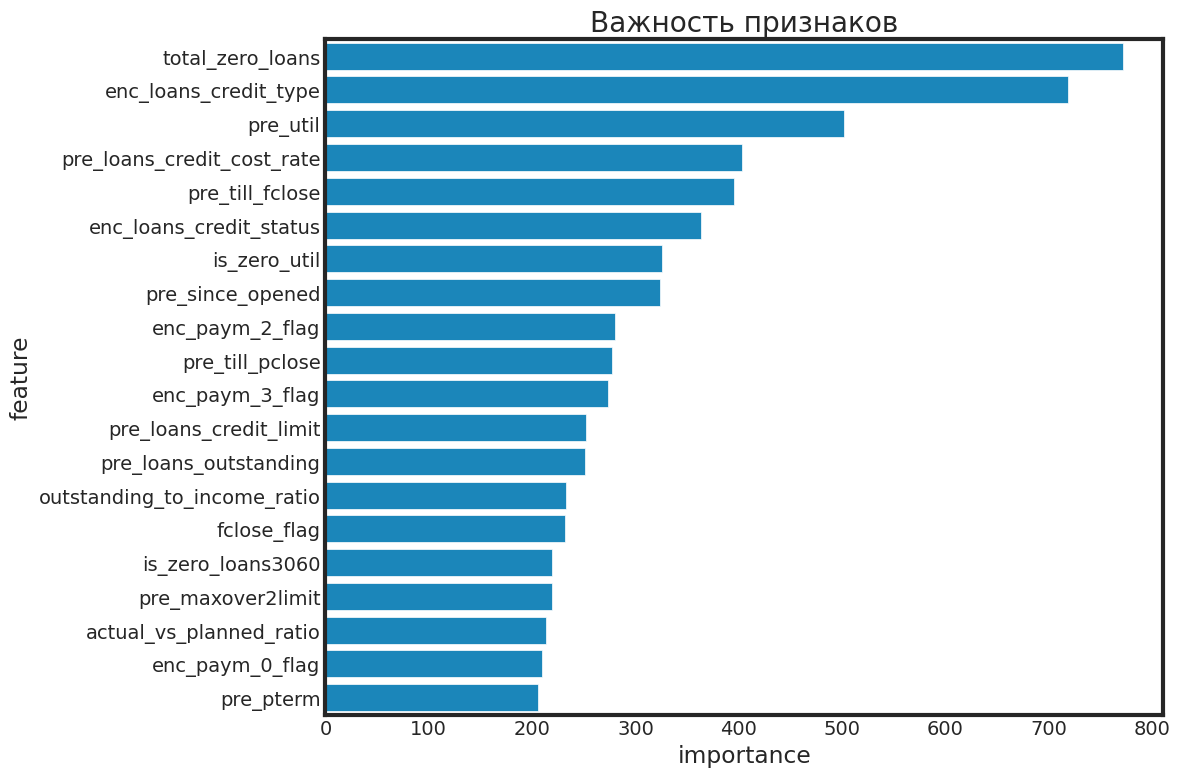

In [ ]:

# Анализ важности признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_lgbm.feature_importances_
}).sort_values('importance', ascending=False)

print(f'Топ-20 важных признаков: {feature_importance.head(20)}')

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Важность признаков')
plt.tight_layout()
plt.show()

**Мониторинг переобучения**

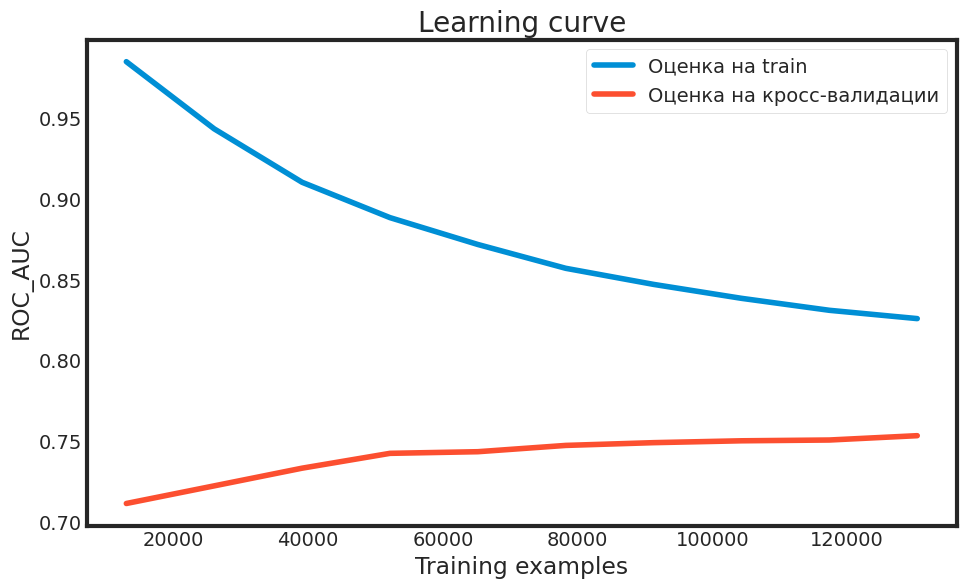

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    best_lgbm, X_train, y_train,
    cv=3, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Оценка на train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Оценка на кросс-валидации')
plt.xlabel('Training examples')
plt.ylabel('ROC_AUC')
plt.title('Learning curve')
plt.legend()
plt.show()